**Emotion Detection Model**<br>
Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/FER-2013/kaggle.json ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download msambare/fer2013

 99% 60.0M/60.3M [00:01<00:00, 38.8MB/s]
100% 60.3M/60.3M [00:01<00:00, 35.5MB/s]


In [ ]:
! unzip fer2013

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

Get Dataset

Data split

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

Reshape into Categorical data

In [ ]:
num_classes = 7
epochs = 55
batch_size = 64
num_features = 32
width, height = 48,48

In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


CNN Model

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    '/content/train',
    class_mode="categorical",
    target_size=(48,48),
    color_mode='rgb',
    shuffle=True,
    batch_size=32,
    subset='training',
)


test_data = test_preprocessor.flow_from_directory(
    '/content/test',
    class_mode="categorical",
    target_size=(48,48),
    color_mode="rgb",
    shuffle=False,
    batch_size=32,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
print(test_dataset.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:

model = Sequential()

#CNN1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

#CNN2
model.add(Conv2D(64, (3,3), activation='relu', ))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

#CNN3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))


#Output
model.add(Flatten())


# model.add(Dense(1024, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7,activation='softmax'))

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

Compile Model

In [ ]:
callbacks=[lrd,mcp,es]

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

Fit Model

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 80,verbose = 1,callbacks=[lrd,mcp])

Epoch 1/80
359/359 [==============================] - 50s 114ms/step - loss: 2.0802 - accuracy: 0.8485 - precision: 0.1832 - recall: 0.0175 - auc: 0.5766 - f1_score: 0.0299 - val_loss: 1.8260 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6516 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/80
359/359 [==============================] - 41s 114ms/step - loss: 1.8570 - accuracy: 0.8552 - precision: 0.2447 - recall: 0.0065 - auc: 0.6445 - f1_score: 0.0125 - val_loss: 1.7854 - val_accuracy: 0.8567 - val_precision: 0.2564 - val_recall: 0.0017 - val_auc: 0.6734 - val_f1_score: 0.0034 - lr: 0.0010
Epoch 3/80
359/359 [==============================] - 40s 111ms/step - loss: 1.7832 - accuracy: 0.8562 - precision: 0.3504 - recall: 0.0077 - auc: 0.6772 - f1_score: 0.0150 - val_loss: 1.7543 - val_accuracy: 0.8567 - val_precision: 0.4752 - val_recall: 0.0317 - val_auc: 0.6872 - val_f1_score: 0.0586 - lr: 0.0010
Epoch 4/80
359/359 [==========================

Evaluate Model

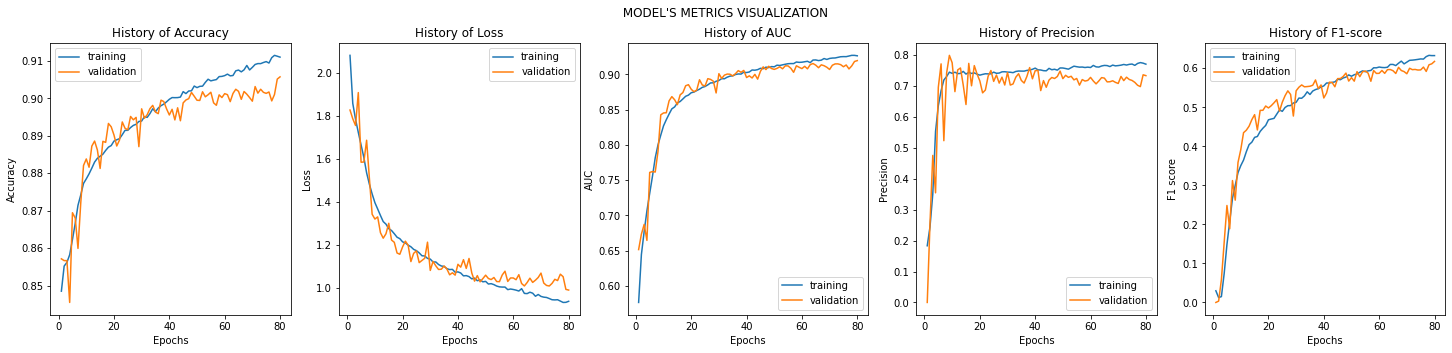

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (25,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
CNN_Score = model.evaluate(test_data)
print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

225/225 [==============================] - 5s 21ms/step - loss: 0.9902 - accuracy: 0.9064 - precision: 0.7294 - recall: 0.5483 - auc: 0.9196 - f1_score: 0.6129
    Test Loss: 0.99018
Test Accuracy: 90.64%


In [ ]:
CNN_Predictions = model.predict(test_data)
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

225/225 [==============================] - 3s 12ms/step


Text(0.5, 1.0, 'CNN Confusion Matrix')

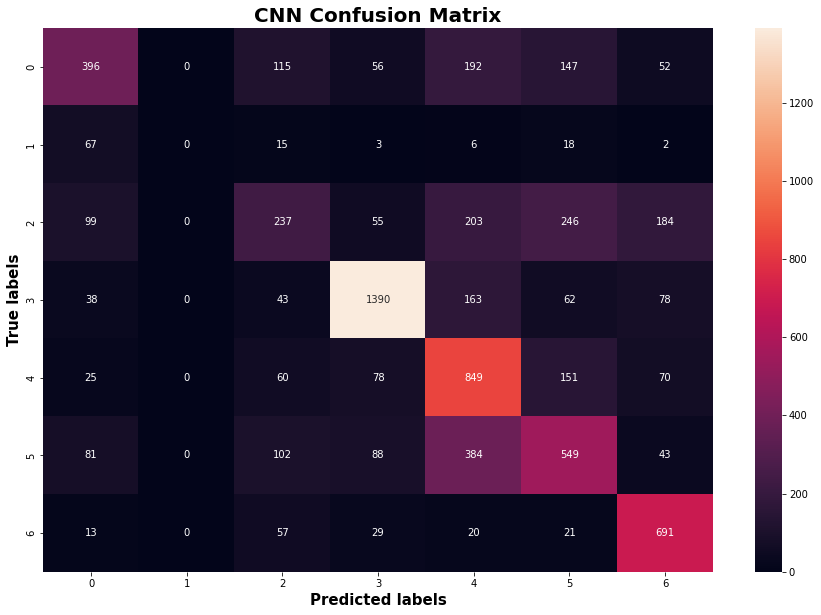

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

In [ ]:
from google.colab import files
import json
model_json = model.to_json()
with open("cnn-model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("cnn-model.h5")
model.save('cnn-model12.h5')
print("Saved model to disk")


Saved model to disk


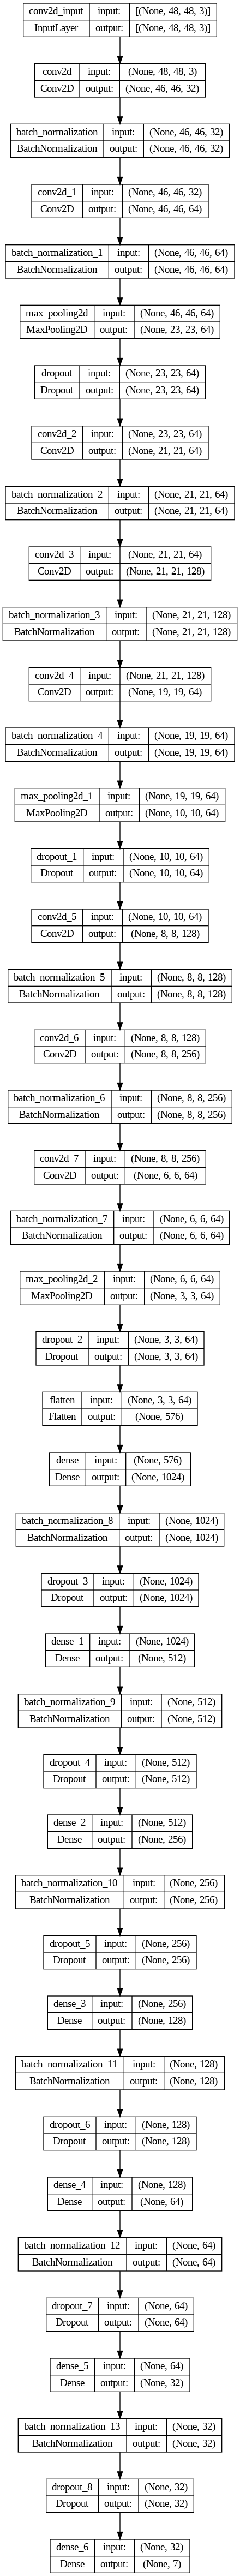

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)

In [ ]:

!pip3 install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=046d994fcb29a951b331580aba2e0b4304e6cb878d0b0780f7a1b45a9b24fc4c
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import face_recognition
from keras.models import model_from_json

In [ ]:
lmodel = model_from_json(open("/content/drive/MyDrive/dataset/cnn-model.json", "r").read())
lmodel.load_weights('/content/drive/MyDrive/dataset/cnn-model.h5')

In [ ]:
import cv2
import os



In [ ]:
def load_images_from_folder(folder, nfolder):
  face_cascade=cv2.CascadeClassifier("/content/drive/MyDrive/dataset/haarcascade_frontalface_default.xml")
  images = []
  for mood in os.listdir(folder):
    os.mkdir(os.path.join(nfolder, mood))
    for filename in os.listdir(os.path.join(folder, mood)):
      img = cv2.imread(os.path.join(folder, mood,filename))
      if img is not None:
        # train = face_recognition.load_image_file(os.path.join(folder, mood,filename))
        # faces = face_recognition.face_locations(train)
        faces = face_cascade.detectMultiScale(img, 1.32, 5)

        for (x,y,w,h) in faces:
          roi_Img = img[ y: y + h , x: x + w ]
          RGBImg= cv2.resize(roi_Img,(48,48), interpolation=cv2.INTER_AREA)
          cv2.imwrite(os.path.join(nfolder, mood,filename), RGBImg)


In [ ]:
load_images_from_folder("/content/drive/MyDrive/Test", "/content/drive/MyDrive/NewTest")

In [ ]:
test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

In [ ]:
test_dataset = test_preprocessor.flow_from_directory(
    "/content/drive/MyDrive/NewTest",
    class_mode="categorical",
    target_size=(48,48),
    color_mode="rgb",
    shuffle=False,
    batch_size=32,
)

Found 32 images belonging to 7 classes.


In [ ]:
CNN_Predictions = lmodel.predict(test_dataset)
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

1/1 [==============================] - 0s 97ms/step


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
print("Test Accuracy: {:.2f}%".format(accuracy_score(test_dataset.labels, CNN_Predictions)))

Test Accuracy: 0.72%
